# Image Prompt

In [1]:
import numpy as np
import rp
import torch
import torch.nn as nn
import source.stable_diffusion as sd
from easydict import EasyDict
from source.learnable_textures import LearnableImageFourier
from source.stable_diffusion_labels import NegativeLabel
from itertools import chain
import time

/home/llt/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#ONLY GOOD PROMPTS HERE
example_prompts = rp.load_yaml_file('source/example_prompts.yaml')
print('Available example prompts:', ', '.join(example_prompts))

#These prompts are all strings - you can replace them with whatever you want! By default it lets you choose from example prompts
#Here are some on the site! It does take some thought to come up with good ideas; the upside-down should look vaguely like the right-side up to work nicely
prompt_a = rp.gather(example_prompts, 'vegetable'.split())
# prompt_a, prompt_b = rp.gather(example_prompts, 'sailing_ship sailing_ship'.split())

negative_prompt = ''

print()
print('Negative prompt:',repr(negative_prompt))
print()
print('Chosen prompts:')
print('    prompt_a =', repr(prompt_a)) #This will be right-side up

Available example prompts: kitten_in_box, botw_landscape, magic_emma_watson, yorkshire_terrier_santa, norwegian_winter_girl, magic_forest_temple, sailing_ship, bioshock_lighthouse, two_bunnys_hugging, thomas_tank_military, wolf_on_rock, victorial_dress, lolita_dress_magical_elf, pencil_giraffe_head, pencil_penguin, pencil_violin, pencil_orca_whale, pencil_cow, pencil_walrus, pencil_cat_head, pencil_dog_head, ape_with_gun, human_skeleton, gold_coins, golf_ball_in_forest, bear_in_forest, elephant_in_circus, mickey_mouse, mushroom, mario, burger, darth_vader, gandalf, fantasy_city, green_elf_girl, pikachu, spring, fall, winter, summer, miku, pyramids, dinosaur, lipstick, picard, bull_wing, froggo, assasin_creed, moon, minecraft_zombie, pistol, disco_ball, volcano, porche, hawaii_beach, walter_white, dalek, tardis, tennant, weeping_angel, vegetable

Negative prompt: ''

Chosen prompts:
    prompt_a = ['many vegetable, oil painting, octane render']


# New Section

In [3]:
!export HF_ENDPOINT=https://hf-mirror.com

In [3]:
if 's' not in dir():
    model_name="CompVis/stable-diffusion-v1-4"
    gpu='cuda:0'
    s=sd.StableDiffusion(gpu,model_name)
device=s.device

[INFO] sd.py: loading stable diffusion...please make sure you have run `huggingface-cli login`.


Loading pipeline components...: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


[INFO] sd.py: loaded stable diffusion!


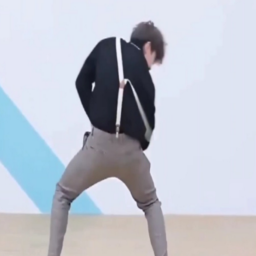

In [4]:
from PIL import Image
import torch
from torchvision import transforms

image_path = "your_image.png"  
image = Image.open(image_path)
if image.mode == 'RGBA':
    image = image.convert('RGB')  

preprocess = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
])

image_tensor = preprocess(image)
rp.display_image(image_tensor)

In [5]:
label_a = NegativeLabel(prompt_a,negative_prompt)
print(label_a)

NegativeLabel(name=['many vegetable, oil painting, octane render'])


In [6]:
#Image Parametrization and Initialization (this section takes vram)

#Select Learnable Image Size (this has big VRAM implications!):
#Note: We use implicit neural representations for better image quality
#They're previously used in our paper "TRITON: Neural Neural Textures make Sim2Real Consistent" (see tritonpaper.github.io)
# ... and that representation is based on Fourier Feature Networks (see bmild.github.io/fourfeat)
learnable_image_maker = lambda: LearnableImageFourier(height=256, width=256, hidden_dim=256, num_features=128).to(s.device); SIZE=256
# learnable_image_maker = lambda: LearnableImageFourier(height=512,width=512,num_features=256,hidden_dim=256,scale=20).to(s.device);SIZE=512

image=learnable_image_maker()

In [7]:
image=learnable_image_maker()
learnable_image_a=lambda: image() #Right-side up

optim=torch.optim.SGD(image.parameters(),lr=1e-4)
labels=[label_a]
learnable_images=[learnable_image_a]

#The weight coefficients for each prompt. For example, if we have [0,1], then only the upside-down mode will be optimized
weights=[1,1]

weights=rp.as_numpy_array(weights)
weights=weights/weights.sum()
weights=weights*len(weights)

In [9]:
#For saving a timelapse
ims=[]

In [10]:
def get_display_image():
    return rp.tiled_images(
        [
            rp.as_numpy_image(learnable_image_a()),
        ],
        length=len(learnable_images),
        border_thickness=0,
    )

In [11]:
print(image_tensor.shape)

torch.Size([3, 256, 256])


In [12]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image

# 加载预训练的CLIP模型和处理器
model_name = "openai/clip-vit-base-patch32"
CLIP = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

# 加载图片
image1 = learnable_image_a()
image2 = image_tensor
def tensor_to_pil(image_tensor):
    return transforms.ToPILImage()(image_tensor)
# 处理图片并提取特征
inputs1 = processor(images=tensor_to_pil(image1), return_tensors="pt", padding=True)
inputs2 = processor(images=tensor_to_pil(image2), return_tensors="pt", padding=True)

with torch.no_grad():
    features1 = CLIP.get_image_features(**inputs1)
    features2 = CLIP.get_image_features(**inputs2)

# 归一化特征向量
features1 = features1 / features1.norm(dim=-1, keepdim=True)
features2 = features2 / features2.norm(dim=-1, keepdim=True)

# 计算余弦相似度
cosine_similarity = torch.nn.functional.cosine_similarity(features1, features2)

print(f"Cosine Similarity: {cosine_similarity.item()}")

Cosine Similarity: 0.5272096991539001


In [13]:
import os
import torch
import torch.nn as nn
from os.path import expanduser  # pylint: disable=import-outside-toplevel
from urllib.request import urlretrieve  # pylint: disable=import-outside-toplevel
def get_aesthetic_model(clip_model="vit_l_14"):
    """load the aethetic model"""
    home = expanduser("~")
    cache_folder = home + "/.cache/emb_reader"
    path_to_model = cache_folder + "/sa_0_4_"+clip_model+"_linear.pth"
    if not os.path.exists(path_to_model):
        os.makedirs(cache_folder, exist_ok=True)
        url_model = (
            "https://github.com/LAION-AI/aesthetic-predictor/blob/main/sa_0_4_"+clip_model+"_linear.pth?raw=true"
        )
        urlretrieve(url_model, path_to_model)
    if clip_model == "vit_l_14":
        m = nn.Linear(768, 1)
    elif clip_model == "vit_b_32":
        m = nn.Linear(512, 1)
    else:
        raise ValueError()
    s = torch.load(path_to_model)
    m.load_state_dict(s)
    m.eval()
    return m

AVA = get_aesthetic_model(clip_model="vit_b_32")

/tmp/ipykernel_2575959/3948651879.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s = torch.load(path_to_model)


In [14]:
print(AVA(CLIP.get_image_features(**inputs1)))
print(AVA(CLIP.get_image_features(**inputs2)))

tensor([[1.7429]], grad_fn=<AddmmBackward0>)
tensor([[17.4638]], grad_fn=<AddmmBackward0>)


In [15]:
NUM_ITER=10000

#Set the minimum and maximum noise timesteps for the dream loss (aka score distillation loss)
s.max_step=MAX_STEP=990
s.min_step=MIN_STEP=10 

display_eta=rp.eta(NUM_ITER, title='Status')

DISPLAY_INTERVAL = 200

print('Every %i iterations we display an image in the form [image_a, image_b], where'%DISPLAY_INTERVAL)
print('    image_a = (the right-side up image)')
print('    image_b = (image_a, but upside down)')
print()
print('Interrupt the kernel at any time to return the currently displayed image')
print('You can run this cell again to resume training later on')
print()
print('Please expect this to take quite a while to get good images (especially on the slower Colab GPU\'s)! The longer you wait the better they\'ll be')

cosine_similarity = []
ava_score = []

try:
    for iter_num in range(NUM_ITER):
        display_eta(iter_num) #Print the remaining time

        preds=[]
        for label,learnable_image,weight in rp.random_batch(list(zip(labels,learnable_images,weights)), batch_size=1):
            pred=s.train_step(
                label.embedding,
                learnable_image()[None],

                #PRESETS (uncomment one):
                noise_coef=.1*weight,guidance_scale=60,target_image=image_tensor
                # noise_coef=0,image_coef=-.01,guidance_scale=50,
                # noise_coef=0,image_coef=-.005,guidance_scale=50,
                # noise_coef=.1,image_coef=-.010,guidance_scale=50,
                # noise_coef=.1,image_coef=-.005,guidance_scale=50,
                # noise_coef=.1*weight, image_coef=-.005*weight, guidance_scale=50,
            )
            preds+=list(pred)
            inputs1 = processor(images=tensor_to_pil(pred[0]), return_tensors="pt", padding=True)
            with torch.no_grad():
                features1 = CLIP.get_image_features(**inputs1)
                features2 = CLIP.get_image_features(**inputs2)
            cosine_similarity.append(torch.nn.functional.cosine_similarity(features1, features2))

            ava_score.append(AVA(features1))

        with torch.no_grad():
            if iter_num and not iter_num%(DISPLAY_INTERVAL*50):
                #Wipe the slate every 50 displays so they don't get cut off
                from IPython.display import clear_output
                clear_output()

            if not iter_num%DISPLAY_INTERVAL:
                im = get_display_image()
                ims.append(im)
                rp.display_image(im)
                rp.display_image(image_tensor)

        optim.step()
        optim.zero_grad()
except KeyboardInterrupt:
    print()
    print('Interrupted early at iteration %i'%iter_num)
    im = get_display_image()
    ims.append(im)
    rp.display_image(im)

Every 200 iterations we display an image in the form [image_a, image_b], where
    image_a = (the right-side up image)
    image_b = (image_a, but upside down)

Interrupt the kernel at any time to return the currently displayed image
You can run this cell again to resume training later on

Please expect this to take quite a while to get good images (especially on the slower Colab GPU's)! The longer you wait the better they'll be


Status: ETR=0:00:00.219584	ETA=0:36:35.835025	T=0:36:35.615441	Progress: 9999/10000

hybird image


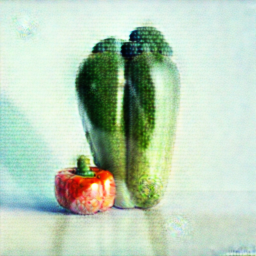

In [16]:
print('hybird image')
rp.display_image(rp.as_numpy_image(learnable_image_a()))

In [17]:
for i in range(10000):
    cosine_similarity[i] = cosine_similarity[i].item()
    ava_score[i] = ava_score[i].item()

In [ ]:
def save_run(name):
    folder="untracked/image_prompt/%s"%name
    if rp.path_exists(folder):
        folder+='_%i'%time.time()
    rp.make_directory(folder)
    ims_names=['ims_%04i.png'%i for i in range(len(ims))]
    with rp.SetCurrentDirectoryTemporarily(folder):
        rp.save_images(ims,ims_names,show_progress=True)
    print()
    print('Saved timelapse to folder:',repr(folder))
    
save_run('no_mask') #You can give it a good custom name if you want!

rp.save_images: Done! Saved 54 images in 0.164 seconds

Saved timelapse to folder: 'untracked/flippy_illusion_runs/no_mask'


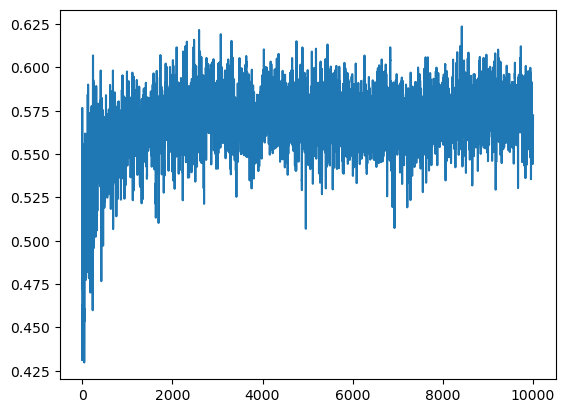

In [55]:
import matplotlib.pyplot as plt
plt.plot(cosine_similarity)

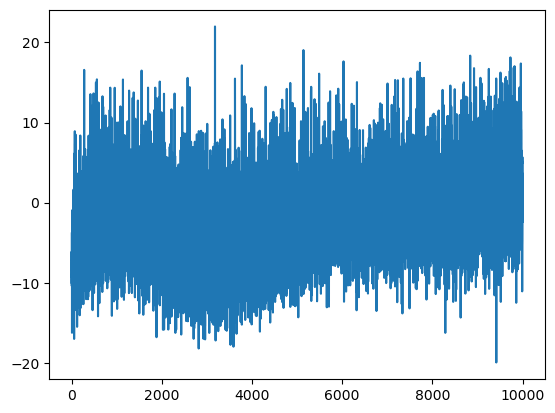

In [19]:
plt.plot(ava_score)

In [56]:
ave_cosine_similarity = cosine_similarity.copy()
ave_ava_score = ava_score.copy()
for i in range(10,10000):
    cosine = 0
    ava = 0
    for j in range(10):
        cosine += cosine_similarity[i - j]
        ava += ava_score[i - j]
    ave_cosine_similarity[i] = cosine / 10
    ave_ava_score[i] = ava / 10

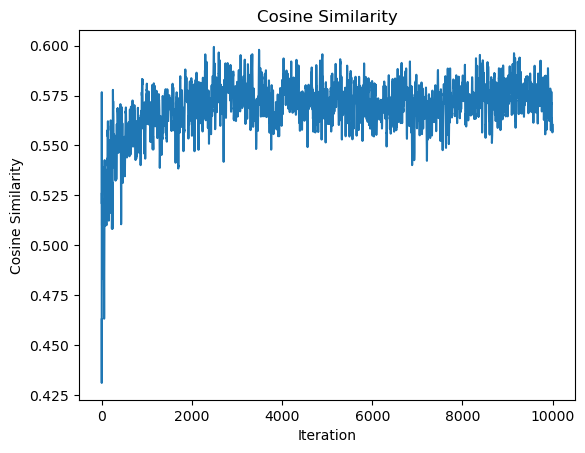

In [57]:
plt.xlabel('Iteration')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity')
plt.plot(ave_cosine_similarity)

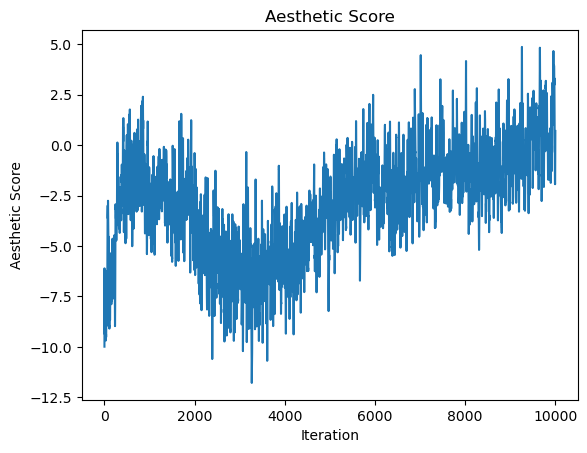

In [58]:
plt.xlabel('Iteration')
plt.ylabel('Aesthetic Score')
plt.title('Aesthetic Score')
plt.plot(ave_ava_score)

In [23]:
with open('cosine_similarity.txt','w') as f:
    f.write('\n'.join(map(str,ave_cosine_similarity)))
with open('ava_score.txt','w') as f:
    f.write('\n'.join(map(str,ave_ava_score)))

In [24]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

def extract_foreground_mask(image_tensor):
    # 使用PIL加载图像
    # image = Image.open(image_path).convert("RGB")

    # # 将图像转换为Tensor
    # transform = transforms.ToTensor()
    # image_tensor = transform(image).unsqueeze(0)  # 添加batch维度

    # 将Tensor转换回NumPy数组以便使用OpenCV
    image_np = image_tensor.squeeze(0).permute(1, 2, 0).numpy()  # 转换为HWC格式
    image_np = (image_np * 255).astype(np.uint8)  # 转换为0-255范围

    # 创建一个与图像大小相同的掩码
    mask = np.zeros(image_np.shape[:2], np.uint8)

    # 定义GrabCut算法使用的背景和前景模型
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # 定义矩形区域，包含前景对象
    height, width = image_np.shape[:2]
    rect = (int(width * 0.1), int(height * 0.1), int(width * 0.8), int(height * 0.8))

    # 应用GrabCut算法
    cv2.grabCut(image_np, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

    # 创建掩码，将确定的前景和可能的前景标记为1，其余为0
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # 将掩码转换为Tensor
    mask_tensor = torch.from_numpy(mask2).float()

    # 将掩码应用到图像上，提取前景
    foreground_tensor = image_tensor * mask_tensor.unsqueeze(0)  # 保持batch维度

    return mask_tensor, foreground_tensor

mask = extract_foreground_mask(image2)

In [25]:
image=learnable_image_maker()
learnable_image_a=lambda: image() #Right-side up

optim=torch.optim.SGD(image.parameters(),lr=1e-4)
labels=[label_a]
learnable_images=[learnable_image_a]

#The weight coefficients for each prompt. For example, if we have [0,1], then only the upside-down mode will be optimized
weights=[1,1]

weights=rp.as_numpy_array(weights)
weights=weights/weights.sum()
weights=weights*len(weights)

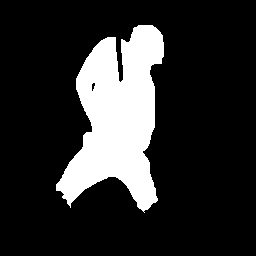

In [26]:
rp.display_image(mask[0].unsqueeze(0).repeat(3, 1, 1))
mask = mask[0].unsqueeze(0).repeat(3, 1, 1)

In [31]:
NUM_ITER=10000

#Set the minimum and maximum noise timesteps for the dream loss (aka score distillation loss)
s.max_step=MAX_STEP=990
s.min_step=MIN_STEP=10 

display_eta=rp.eta(NUM_ITER, title='Status')
cosine_similarity_mask=[]
ava_score_mask=[]

print('Every %i iterations we display an image in the form [image_a, image_b], where'%DISPLAY_INTERVAL)
print('    image_a = (the right-side up image)')
print('    image_b = (image_a, but upside down)')
print()
print('Interrupt the kernel at any time to return the currently displayed image')
print('You can run this cell again to resume training later on')
print()
print('Please expect this to take quite a while to get good images (especially on the slower Colab GPU\'s)! The longer you wait the better they\'ll be')

cosine_similarity = []
ava_score = []

img_mask = []

try:
    for iter_num in range(NUM_ITER):
        display_eta(iter_num) #Print the remaining time

        preds=[]
        for label,learnable_image,weight in rp.random_batch(list(zip(labels,learnable_images,weights)), batch_size=1):
            pred=s.train_step(
                label.embedding,
                learnable_image()[None],

                #PRESETS (uncomment one):
                noise_coef=.1*weight,guidance_scale=60,target_image=image_tensor,mask=mask.unsqueeze(0)
                # noise_coef=0,image_coef=-.01,guidance_scale=50,
                # noise_coef=0,image_coef=-.005,guidance_scale=50,
                # noise_coef=.1,image_coef=-.010,guidance_scale=50,
                # noise_coef=.1,image_coef=-.005,guidance_scale=50,
                # noise_coef=.1*weight, image_coef=-.005*weight, guidance_scale=50,
            )
            preds+=list(pred)
            inputs1 = processor(images=tensor_to_pil(pred[0]), return_tensors="pt", padding=True)
            with torch.no_grad():
                features1 = CLIP.get_image_features(**inputs1)
                features2 = CLIP.get_image_features(**inputs2)
            cosine_similarity_mask.append(torch.nn.functional.cosine_similarity(features1, features2))

            ava_score_mask.append(AVA(features1))

        with torch.no_grad():
            if iter_num and not iter_num%(DISPLAY_INTERVAL*50):
                #Wipe the slate every 50 displays so they don't get cut off
                from IPython.display import clear_output
                clear_output()

            if not iter_num%DISPLAY_INTERVAL:
                im = get_display_image()
                img_mask.append(im)
                #rp.display_image(im)
                #rp.display_image(image_tensor)

        optim.step()
        optim.zero_grad()
except KeyboardInterrupt:
    print()
    print('Interrupted early at iteration %i'%iter_num)
    im = get_display_image()
    img_mask.append(im)
    rp.display_image(im)

Every 200 iterations we display an image in the form [image_a, image_b], where
    image_a = (the right-side up image)
    image_b = (image_a, but upside down)

Interrupt the kernel at any time to return the currently displayed image
You can run this cell again to resume training later on

Please expect this to take quite a while to get good images (especially on the slower Colab GPU's)! The longer you wait the better they'll be


Status: ETR=0:00:00.440141	ETA=0:36:40.705683	T=0:36:40.265542	Progress: 9998/10000

In [35]:
for i in range(10000):
    cosine_similarity_mask[i] = cosine_similarity_mask[i].item()
    ava_score_mask[i] = ava_score_mask[i].item()

In [36]:
def save_run(name):
    folder="untracked/flippy_illusion_runs/%s"%name
    if rp.path_exists(folder):
        folder+='_%i'%time.time()
    rp.make_directory(folder)
    ims_names=['ims_%04i.png'%i for i in range(len(img_mask))]
    with rp.SetCurrentDirectoryTemporarily(folder):
        rp.save_images(img_mask,ims_names,show_progress=True)
    print()
    print('Saved timelapse to folder:',repr(folder))
    
save_run('mask') #You can give it a good custom name if you want!

rp.save_images: Done! Saved 50 images in 0.138 seconds

Saved timelapse to folder: 'untracked/flippy_illusion_runs/mask'


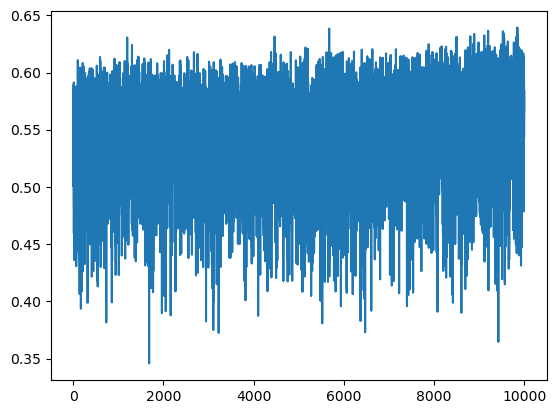

In [37]:
import matplotlib.pyplot as plt
plt.plot(cosine_similarity_mask)

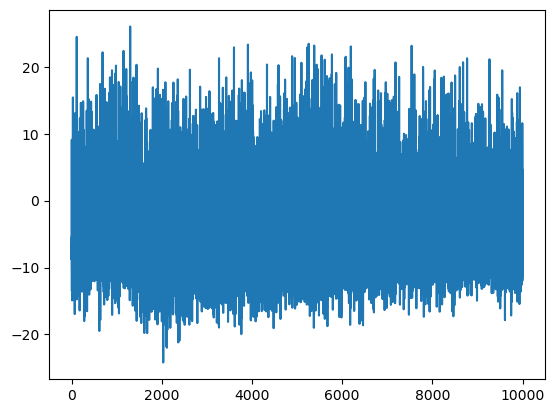

In [38]:
plt.plot(ava_score_mask)

In [60]:
ave_cosine_similarity_mask = cosine_similarity_mask.copy()
ave_ava_score_mask = ava_score_mask.copy()
for i in range(4,10000):
    ave_cosine_similarity_mask[i] = (cosine_similarity_mask[i - 4]+ cosine_similarity_mask[i - 3] + cosine_similarity_mask[i - 2] + cosine_similarity_mask[i - 1] + cosine_similarity_mask[i]) / 5.0
    ave_ava_score_mask[i] = (ava_score_mask[i - 4]+ ava_score_mask[i - 3] + ava_score_mask[i - 2] + ava_score_mask[i - 1] + ava_score_mask[i]) / 5.0
a_cosine_similarity_mask = ave_cosine_similarity_mask.copy()
a_ava_score_mask = ave_ava_score_mask.copy()
for i in range(10,10000):
    cosine = 0
    ava = 0
    for j in range(10):
        cosine += a_cosine_similarity_mask[i - j]
        ava += a_ava_score_mask[i - j]
    ave_cosine_similarity_mask[i] = cosine / 10
    ave_ava_score_mask[i] = ava / 10

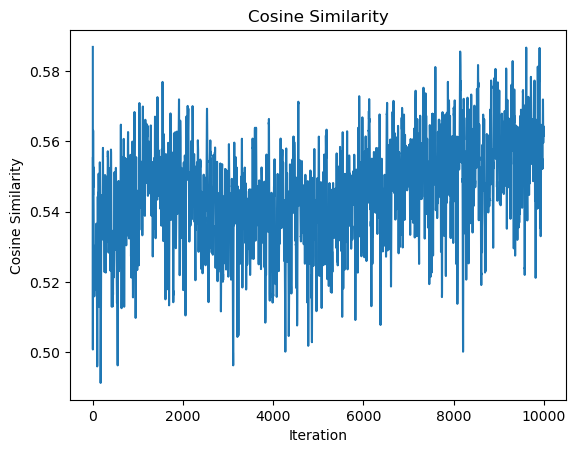

In [61]:
plt.xlabel('Iteration')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity')
plt.plot(ave_cosine_similarity_mask)

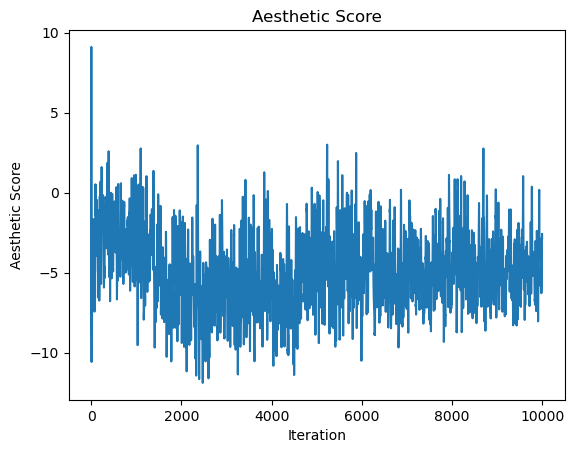

In [62]:
plt.xlabel('Iteration')
plt.ylabel('Aesthetic Score')
plt.title('Aesthetic Score')
plt.plot(ave_ava_score_mask)

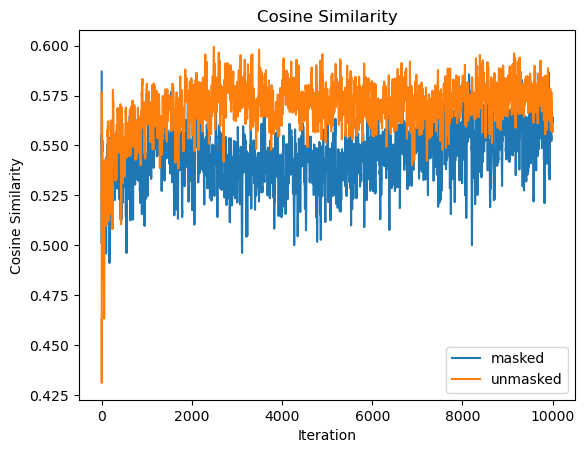

In [63]:
plt.xlabel('Iteration')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity')
plt.plot(ave_cosine_similarity_mask,label='masked')
plt.plot(ave_cosine_similarity,label='unmasked')
plt.legend()

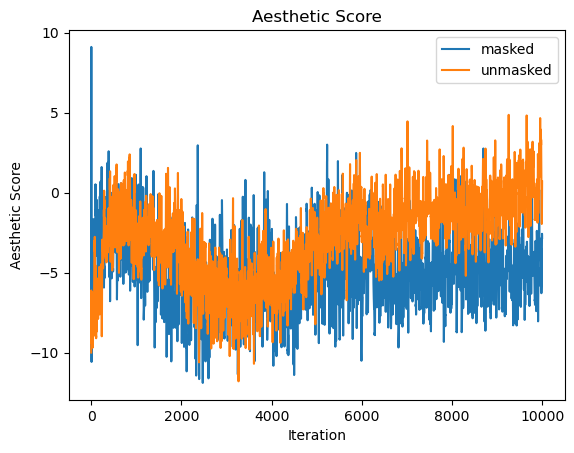

: 

In [64]:
plt.xlabel('Iteration')
plt.ylabel('Aesthetic Score')
plt.title('Aesthetic Score')
plt.plot(ave_ava_score_mask,label='masked')
plt.plot(ave_ava_score,label='unmasked')
plt.legend()

In [51]:
with open('cosine_similarity_mask.txt','w') as f:
    f.write('\n'.join(map(str,ave_cosine_similarity_mask)))
with open('ava_score_mask.txt','w') as f:
    f.write('\n'.join(map(str,ave_ava_score_mask)))